# RAG Model Pipeline without Reformulation

This notebook implements a baseline Retrieval-Augmented Generation (RAG) pipeline without any query reformulation. It is developed as part of UNHCR chatbot experimentation to evaluate how raw user queries perform when passed directly to a retriever-augmented LLM. 

### Step 1: Imports and Environment Setup

This section imports libraries, downloads required NLTK data, and loads environment variables.

In [1]:
# LangChain components for building RAG pipeline 
from langchain.schema import Document                              # Core document type used in LangChain
from langchain.text_splitter import RecursiveCharacterTextSplitter # Splits text into chunks with overlap
from langchain.embeddings import HuggingFaceEmbeddings             # Embedding wrapper using HuggingFace models
from langchain.vectorstores import Pinecone                        # Vector store connector for Pinecone
from langchain.docstore.in_memory import InMemoryDocstore          # Optional in-memory storage (e.g. for debugging or chaining)
from langchain.prompts import PromptTemplate                       # Template for creating prompts and specifying input/output formats for LLMs
from langchain.llms import HuggingFacePipeline                     # Use HuggingFace pipelines as LLMs
from langchain.chains import LLMChain                              # Basic chain to connect prompt + LLM

# External dependencies
import pinecone                                                    # Pinecone client for vector storage
import os                                                          # OS tools for accessing environment variables
from dotenv import load_dotenv                                     # Load environment variables from .env file
import json                                                        # For reading/writing JSON configs or outputs
import docx                                                        # For reading .docx files  

# NLTK for tokenization                                                                                         
from nltk.tokenize import word_tokenize                            # Tokenizes strings into words
import nltk                                                        # Natural Language Toolkit — useful for preprocessing tasks

# HuggingFacce transformers for LLMs and pipelines
from transformers import pipeline                                  # For loading pre-trained NLP models


# Download required NLTK tokenizer models
nltk.download('punkt')                                             # Sentence & word tokenizer model
nltk.download('punkt_tab')                                         # Associated tokenizer table



c:\Users\eloe23ac\Documents\RAG-Model\rag_model_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eloe23ac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eloe23ac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Step 2: Document Preprocessing


Create functions to convert DOCX filenames to URLs, extract text from DOCX files, and load documents with metadata (source/URLs). 


In [2]:
def docx_filename_to_url(filename: str) -> str:
    """"
    Convert a filename like:
        help.unhcr.org_denmark_about-unhcr-in-denmark_.docx
    to a proper URL like:
        https://help.unhcr.org/denmark/about-unhcr-in-denmark/

    This function removes the .docx extension, splits the remaining string 
    by underscores, and builds a structured UNHCR help site URL.
    """
    # Remove the .docx extension, split by underscores, and filter out empty parts
    name_no_ext = filename.replace(".docx", "")     
    parts = name_no_ext.split("_")                   
    parts = [p for p in parts if p]              
    
    # If there are no parts, return an empty string, otherwise build the URL, assume the first part is the domain and the rest are path segments. 
    # If there are parts, join them with slashes and return the URL.
    if not parts:
        return ""
    domain = parts[0]
    path_parts = parts[1:]
    url = "https://" + domain + "/"
    if path_parts:
        url += "/".join(path_parts) + "/"
    return url


In [3]:
def build_doc_url_dict(raw_folder: str) -> dict:
    """
    Iterate through all .docx files in the given folder and build a mapping:
    {full_file_path: corresponding UNHCR help site URL}.

    This helps preserve a reference to the original source when loading document content.
    """
    # Initialize an empty directory to store the mapping of file paths to URLs.
    doc_url_dict = {}
    for filename in os.listdir(raw_folder):
        if filename.endswith(".docx"):
            doc_path = os.path.join(raw_folder, filename)
            url = docx_filename_to_url(filename)
            doc_url_dict[doc_path] = url
    return doc_url_dict

In [4]:
# Get all DOCX files from data directory
data_dir = "../data/raw"
docx_files = [f for f in os.listdir(data_dir) if f.endswith('.docx')]

# Manual inspection to verify the resulting URLs look valid and follow the UNHCR structure.
print("\n Generated URLs from DOCX files:")
print("-" * 80)
for i, filename in enumerate(docx_files, 1):
    url = docx_filename_to_url(filename)
    print(f"{i:02d}. {url}")
print("-" * 80)
print(f"Total URLs: {len(docx_files)}")


 Generated URLs from DOCX files:
--------------------------------------------------------------------------------
01. https://help.unhcr.org/denmark/about-unhcr-in-denmark/
02. https://help.unhcr.org/denmark/applying-for-family-reunification/
03. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/
04. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/can-i-appeal-a-negative-decision/
05. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/how-to-apply-for-asylum/
06. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/i-need-a-lawyer-and-or-an-interpreter-in-my-case/
07. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/what-are-my-rights-and-obligations-as-asylum-seeker/
08. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/what-can-be-the-decision-in-my-case/
09. https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/what-happens-after-i-apply-for-asylum/
10. https://help.unhcr.org/

In [5]:
def extract_text_from_docx(docx_path: str) -> str:
    """
    Extract all text content from a .docx file, paragraph by paragraph,
    skipping empty lines, and join them using newlines.
    """
    # Load the .docx file, loop through paragraphs, and extract text. Skip empty lines and return fully joined text.
    document = docx.Document(docx_path)
    paragraphs = []
    for para in document.paragraphs:
        text = para.text.strip()
        if text:  
            paragraphs.append(text)
    return "\n".join(paragraphs)




In [6]:

def load_docs_with_metadata(raw_folder: str):
    """
    Load each .docx file from the folder, extract its text content,
    and return a list of LangChain Document objects with metadata.

    Metadata includes the source URL derived from the filename.
    """
    doc_url_dict = build_doc_url_dict(raw_folder)  #  Dictionary {full_docx_path: URL}
    docs = []
    
    # Iterate through each document path and its associated URL and extract text content.
    for doc_path, url in doc_url_dict.items():
        text = extract_text_from_docx(doc_path)
    # Skip empty lines and create a LangChain Document object with the text and metadata. 
        if text.strip():
            docs.append(
                Document(
                    page_content=text,
                    metadata={"source": url}
                )
            )
    return docs


In [7]:

raw_folder = "../data/raw"

docs = load_docs_with_metadata(raw_folder)
print(docs[0].metadata)
print(docs[0].page_content) 

{'source': 'https://help.unhcr.org/denmark/about-unhcr-in-denmark/'}
About UNHCR in Denmark
https://help.unhcr.org/denmark/about-unhcr-in-denmark/
All information and services provided by UNHCR and our partners are FREE OF CHARGE for temporary protection beneficiaries, asylum-seekers, refugees, beneficiaries of subsidiary protection and stateless persons.
UNHCR works to protect the rights and support better futures for temporary protection beneficiaries, asylum-seekers, refugees and people at risk of statelessness worldwide.
In Denmark, UNHCR supports the national authorities in executing their duties in line with international and European standards. UNHCR is not part of the asylum procedure in Denmark. The asylum procedure in Denmark is under the responsibility of the Danish Immigration Service under the Danish Ministry of Immigration and Integration.
UNHCR in Denmark is part of UNHCR’s Representation for the Nordic and Baltic Countries (https://www.unhcr.org/neu/), based in Stockhol

### Step 3: Document Splitting and Vector Embeddings

This step splits documents into chunks (child documents) and computes embeddings to be upserted into Pinecone.

In [8]:
# Parent-Child Chunking:

# Initialize lists to store full documents (parents) and smaller chunks (children)
parent_docs = []
child_docs = []

#  Define a text splitter to chunk large texts into manageable pieces with overlap for context preservation
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

# Loop through each full document
for doc in docs:
    # Save the full document (parent)
    parent_docs.append(doc)
    
    # Split the document's content into smaller overlapping chunks
    splitted_texts = text_splitter.split_text(doc.page_content)
    
    #  For each chunk, create a LangChain Document and reference the original document's (parent doc) metadata
    for chunk_text in splitted_texts:
        child_docs.append(
            Document(
                page_content=chunk_text,
                metadata={
                    "parent_source": doc.metadata["source"], 
                }
            )
        )

In [9]:
# Initialize Embedding model
"""
Here the multilingual embedding model is initialized from Hugging Face for generating dense vector
representations of text chunks. This model will be used to embed all the child documents
before indexing them in a vector store (e.g., Pinecone).

We're using the 'intfloat/multilingual-e5-base' model, which is:
- Open-source and locally loadable via LangChain (no external API required)
- Designed for sentence-level embeddings in multiple languages
- Well-suited for low-resource languages, making it appropriate for UNHCR's global scope

By using HuggingFaceEmbeddings (rather than hosted APIs like OpenAI), we ensure:
- Full control over performance and deployment
- Scalability in secure, cost-effective environments
- Easy model replacement or fine-tuning for specific regions/languages
"""
embedding_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-base")



c:\Users\eloe23ac\Documents\RAG-Model\rag_model_env\Lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Generate embeddings for all child document chunks using the multilingual model (E5 multilingual base)
texts = [child.page_content for child in child_docs]
vectors = embedding_model.embed_documents(texts)

### Step 4: Pinecone Index Setup
This step initializes Pinecone, creates the index (if needed), and upserts the vector embeddings.



In [11]:
from pinecone import Pinecone
"""
Initialize Pinecone using the official client (not LangChain wrapper).
We connect directly via API key and specify the cloud region. This gives us
full control over index management (e.g., creating, checking, upserting).

We're not using LangChain's Pinecone wrapper here due to dependency issues.
This approach is more flexible and can be maintained independently of LangChain versions.
"""
# 1. Initialize Pinecone client using direct API key and region which are stored in environment for security.  
pc = Pinecone(
    api_key=os.getenv("PINECONE_API_KEY"),
    environment="us-east-1-aws",
    region="us-east-1"
)
# 2. Define the name of the vector index to use. If it does not exist, create it. 
index_name = "unhcr-chatbot"

if not pc.has_index(index_name):
    pc.create_index(index_name, dimension=len(vectors[0]))

# 3. Connect to the existing or newly created index
index = pc.Index(index_name)


In [12]:
"""
Prepare a list of (id, vector, metadata) tuples for each embedded child chunk.

Each entry is uniquely identified (e.g., "child_0"), and includes:
- The vector: high-dimensional embedding from Step 3
- The metadata: source URL and full chunk text for later reference

These are then uploaded (upserted) into the specified Pinecone namespace.
"""

to_upsert = []

# Loop through each embedded child document and pair it with metadata
for i, child_doc in enumerate(child_docs):
    to_upsert.append((
        f"child_{i}",                                          # Unique ID for the chunk
        vectors[i],                                            # Embedding vector for the chunk
        {
        "parent_source": child_doc.metadata["parent_source"],  # Trace back to full doc
        "text": child_doc.page_content}                        # Store the raw chunk text for retrieval                   
    ))

# Upload vectors and metadata to Pinecone under a namespace "text_chunks"
index.upsert(to_upsert, namespace="text_chunks")

{'upserted_count': 333}

In [ ]:
# Delete all vectors from the index
#index.delete(delete_all=True)

#print("All vectors deleted from Pinecone index")

### Step 5: Retrieval and Reranking
This step initializes the CrossEncoder for reranking, embedds the query, retrives top k results from Pinecone, reranks the top k with reranking and returns those chunks. 

In [13]:
from sentence_transformers import CrossEncoder

"""
Initialize the reranker using a local CrossEncoder model.

We're using BAAI's bge-reranker-base model, loaded via sentence-transformers.
This model takes pairs of (query, document) and assigns a relevance score.

This approach is:
- Fully local (no API calls)
- Fast when using a GPU (device=0)
- Swappable with other reranker models if needed (Scalable solution)
"""

reranker = CrossEncoder("BAAI/bge-reranker-base", device=0)


In [15]:
def store_retrieve_and_rerank(query, top_k_retrieve=5, top_k_rerank=3):
    """
    Takes a raw user query (no reformulation) and performs:
    - Dense embedding of the query,
    - Top-k semantic retrieval from Pinecone,
    - Reranking using a local CrossEncoder model,
    - Returns the top reranked results (content + source URL).

    This version of the pipeline skips query reformulation,
    based on evaluation results showing better performance without it.
    """
    # Embed the raw query using the multilingual embedding model
    query_vector = embedding_model.embed_query(query)

    # Retrieve top-k most relevant chunks from Pinecone based on vector similarity
    results = index.query(
        vector=query_vector,
        top_k=top_k_retrieve,  
        includeMetadata=True,
        namespace="text_chunks"
    )

    # Collect retrieved documents with their content and metadata
    retrieved_docs = []
    for match in results["matches"]:
        text_content = match["metadata"].get("text", "").strip()
        source_url = match["metadata"].get("parent_source", "").strip()
        if text_content:
            retrieved_docs.append({
                "id": match["id"],
                "score": match["score"],
                "content": text_content,
                "source": source_url
            })
    # Handle empty results
    if not retrieved_docs:
        print("\n No documents retrieved from Pinecone! Try a different query.")
        return []
    # Rerank retrieved documents using a local CrossEncoder model
    query_doc_pairs = [(query, doc["content"]) for doc in retrieved_docs]
    rerank_scores = reranker.predict(query_doc_pairs)
    # Attach rerank scores to each document
    for i, doc in enumerate(retrieved_docs):
        doc["rerank_score"] = rerank_scores[i]
    # Sort by rerank score and return top-k
    reranked_docs = sorted(retrieved_docs, key=lambda x: x["rerank_score"], reverse=True)[:top_k_rerank]
    return reranked_docs


### Step 6: Answer Generation with Phi-3.5 Mini

This step loads the Phi-3.5 model, creates the text-generation pipeline, and defines the final answer generation function.

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Clear GPU memory (recommended if multiple large models are being loaded)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

"""
Load the Phi-3.5 Mini Instruct model and tokenizer from Hugging Face locally.
This is a lightweight, open-source LLM designed for instruction-following.

Benefits for UNHCR:
- Local and offline capable
- Lightweight (efficient on consumer GPUs)
- Safe, cost-effective alternative to OpenAI/Anthropic APIs
"""
model_name = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16,
    device_map="auto",
    max_memory={0: "30GB"},
    use_cache=True
)

# Wrap the model in a text-generation pipeline with decoding configs
phi_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=200,
    temperature=0.7,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    #return_full_text=False
)
# Convert to LangChain-compatible wrapper
final_llm = HuggingFacePipeline(pipeline=phi_pipeline)
print("Phi-3.5 Mini Model Loaded Successfully!")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:09<00:00,  4.51s/it]

Phi-3.5 Mini Model Loaded Successfully!


In [17]:
# Structured prompt with system message, context, user input, and strict generation rules
# Clear prompt structure ensures consistency and limits hallucinations, context injection enables real-time grounded responses.
# Templates are reusable and easy to adapt for other regions or languages (scalable solution). 

prompt_template = prompt_template = """SYSTEM: You are a chatbot specializing in UNHCR and refugee services in Denmark. 
Answer the user’s question concisely and directly using the provided CONTEXT. 
If the question is not related to UNHCR or refugee services, respond with: "I'm sorry, I can only answer questions related to UNHCR and refugee services in Denmark."
If the answer is incomplete (e.g., if a question asks for detailed steps, like "What happens after I apply for asylum?"), provide as many relevant details as possible.
At the end of your answer, if an answer is available, add a note: "For additional information, please visit: {sources}"

CONTEXT: {context}

USER QUERY: {query}

INSTRUCTIONS:
- Answer concisely in 2-3 sentences.
- Include detailed steps if applicable.
- Do NOT generate follow-up questions.
- Do NOT continue generating after your answer.
- If unsure or off-topic, reply with: "I'm sorry, I can only answer questions related to UNHCR and refugee services in Denmark."

FINAL RESPONSE:
"""




In [18]:
def generate_answer_without_reformulation(user_query):
    """
    Generates an answer using the original (unmodified) query.
    - Retrieves and reranks relevant document chunks.
    - Constructs a context-aware prompt.
    - Runs the prompt through Phi-3.5 Mini for generation.
    - Returns a clean, final answer.
    """
    # Use the original query as is
    final_query = user_query.strip()

    # Retrieve and rerank using the original query directly
    reranked_docs = store_retrieve_and_rerank(final_query, top_k_retrieve=5, top_k_rerank=3)
    
    # Extract context from the top reranked documents
    context = "\n\n".join([doc["content"][:500] for doc in reranked_docs])
    
    # Extract unique source URLs for the final note
    sources = list({doc.get("source", "") for doc in reranked_docs if doc.get("source", "")})
    sources_str = ", ".join(sources) if sources else "N/A"
    
    # Format the prompt using the original query
    formatted_prompt = prompt_template.format(context=context, query=final_query, sources=sources_str)
    
    # Run the Phi-3.5 model with the formatted prompt
    response = final_llm(formatted_prompt)
    
    if isinstance(response, list) and len(response) > 0:
        response_text = response[0]["generated_text"] if isinstance(response[0], dict) else response[0]
    else:
        response_text = response.strip() if isinstance(response, str) else str(response)
    
    # Return only the first paragraph as the final answer
    clean_answer = response_text.split("\n\n")[0].strip()
    return clean_answer




### Step 7: Main Execution & Evaluation 
This final section tests the full pipeline with sample queries and evaluates metrics. 

#### 7.1 Query Time Evaluation

In [19]:
# Run a single sample query through the full RAG pipeline (no reformulation)
query = "What does UNHCR do in Denmark?"
answer = generate_answer_without_reformulation(query)
print("\nAnswer:", answer)




You are not running the flash-attention implementation, expect numerical differences.



Answer: UNHCR in Denmark supports national authorities in executing their duties according to international and European standards. It is not involved in the actual asylum procedure, which is managed by the Danish Immigration Service. UNHCR also operates within the Nordic and Baltic Representation based in Stockholm to coordinate efforts across the region. For additional information, please visit: https://help.unhcr.org/denmark/about-unhcr-in-denmark/ and https://help.unhcr.org/denmark/uk/about-unhcr-in-denmark/.


In [20]:
import time

"""
Evaluate response time across multiple components:
- Embedding
- Retrieval from Pinecone
- Reranking
- Generation (LLM response)

Tested with both normal and misspelled (fuzzy) queries to evaluate robustness.
"""

# Define the list of test queries
queries = [
    "What does UNHCR do in Denmark?",
    "How can I apply for family reunification?",
    "How do I apply for asylum in Denmark?",
    "Can I appeal a negative asylum decision?",
    "How can I get a lawyer or interpreter for my asylum case?",
    "Wat duz UNHCR du in danmrk?",
    "How kan I apley for famly reunificashun?",
    "How du I apley for asylm in danmrk?"
]

# Lists to store times for each component
embedding_times = []
pinecone_times = []
reranker_times = []
generation_times = []
total_times = []

# Loop over each query and record timings for each component
for query in queries:
    print("Testing query:", query)
    
    # Start total timing for the query
    start_total = time.time()
    
    # 1. Time the query embedding
    start = time.time()
    query_vector = embedding_model.embed_query(query)
    embedding_time = time.time() - start
    embedding_times.append(embedding_time)
    print("Embedding time: {:.4f}s".format(embedding_time))
    
    # 2. Time the Pinecone query
    start = time.time()
    results = index.query(
        vector=query_vector,
        top_k=5,
        includeMetadata=True,
        namespace="text_chunks"
    )
    pinecone_time = time.time() - start
    pinecone_times.append(pinecone_time)
    print("Pinecone query time: {:.4f}s".format(pinecone_time))
    
    # 3. Build retrieved_docs from results
    retrieved_docs = []
    for match in results["matches"]:
        text_content = match["metadata"].get("text", "").strip()
        source = match["metadata"].get("parent_source", "").strip()
        if text_content:
            retrieved_docs.append({
                "id": match["id"],
                "score": match["score"],
                "content": text_content,
                "source": source
            })
    
    # 4. Time the reranking step
    start = time.time()
    query_doc_pairs = [(query, doc["content"]) for doc in retrieved_docs]
    rerank_scores = reranker.predict(query_doc_pairs)
    reranker_time = time.time() - start
    reranker_times.append(reranker_time)
    print("Reranker time: {:.4f}s".format(reranker_time))
    
    # 5. Prepare the prompt
    sources = list({doc.get("source", "") for doc in retrieved_docs if doc.get("source", "")})
    sources_str = ", ".join(sources) if sources else "N/A"
    context = "\n\n".join([doc["content"][:500] for doc in retrieved_docs])
    formatted_prompt = prompt_template.format(context=context, query=query, sources=sources_str)
    
    # 6. Time the generation step
    start = time.time()
    response = final_llm(formatted_prompt)
    generation_time = time.time() - start
    generation_times.append(generation_time)
    print("Generation time: {:.4f}s".format(generation_time))
    
    # End total timing for the query
    total_time = time.time() - start_total
    total_times.append(total_time)
    print("Total query time: {:.4f}s\n".format(total_time))

# Calculate and print average times for each component and total time
avg_embedding = sum(embedding_times) / len(embedding_times)
avg_pinecone = sum(pinecone_times) / len(pinecone_times)
avg_reranker = sum(reranker_times) / len(reranker_times)
avg_generation = sum(generation_times) / len(generation_times)
avg_total = sum(total_times) / len(total_times)

print("Average Embedding time: {:.4f}s".format(avg_embedding))
print("Average Pinecone query time: {:.4f}s".format(avg_pinecone))
print("Average Reranker time: {:.4f}s".format(avg_reranker))
print("Average Generation time: {:.4f}s".format(avg_generation))
print("Average Total query time: {:.4f}s".format(avg_total))

Testing query: What does UNHCR do in Denmark?
Embedding time: 0.0150s
Pinecone query time: 0.8070s
Reranker time: 0.0220s
Generation time: 17.6411s
Total query time: 18.4861s

Testing query: How can I apply for family reunification?
Embedding time: 0.0150s
Pinecone query time: 0.1110s
Reranker time: 0.0300s
Generation time: 11.6950s
Total query time: 11.8520s

Testing query: How do I apply for asylum in Denmark?
Embedding time: 0.0140s
Pinecone query time: 0.1110s
Reranker time: 0.0220s
Generation time: 13.9691s
Total query time: 14.1170s

Testing query: Can I appeal a negative asylum decision?
Embedding time: 0.0210s
Pinecone query time: 0.1090s
Reranker time: 0.0320s
Generation time: 9.5130s
Total query time: 9.6750s

Testing query: How can I get a lawyer or interpreter for my asylum case?
Embedding time: 0.0200s
Pinecone query time: 0.3250s
Reranker time: 0.0280s
Generation time: 18.1151s
Total query time: 18.4901s

Testing query: Wat duz UNHCR du in danmrk?
Embedding time: 0.0240s


In [ ]:
#!pip install matplotlib

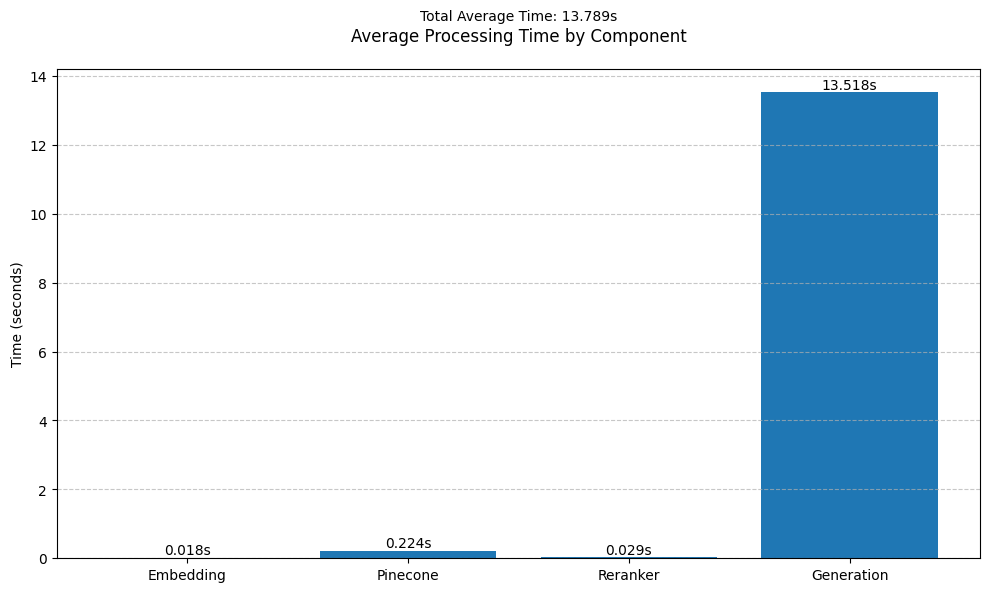

In [21]:
import matplotlib.pyplot as plt
import numpy as np

"""
Generate a bar chart showing average time spent per RAG component, plus a total average time label.

Helps identify performance for optimization. This is compared with the previous version of the pipeline, 
which included query refromulation.
"""

# Prepare data
components = ['Embedding', 'Pinecone', 'Reranker', 'Generation']
times = [avg_embedding, avg_pinecone, avg_reranker, avg_generation]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(components, times)

# Customize the plot
plt.title('Average Processing Time by Component', pad=20)
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}s',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=0)

# Add total time as text
plt.text(0.5, 1.1, f'Total Average Time: {avg_total:.3f}s',
         ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout()
plt.show()



#### 7.2 Evaluation Metrics

In this section, we assess the performance of our RAG model's query generation capabilities. We'll analyze a comprehensive test set consisting of 40 diverse user queries and their corresponding expected responses, which have been documented in our evaluation spreadsheet. This structured approach allows us to:

- Measure the accuracy of generated responses
- Compare model outputs against human-verified answers
- Identify potential areas for improvement
- Evaluate the model's understanding across different query types

In [ ]:
#!pip install rouge
#!pip install seaborn
#!pip install openpyxl

In [ ]:
import pandas as pd

# Read the evalution Excel file into a DataFrame
df = pd.read_excel("../Evaluation/Component Evaluation For Python.xlsx")

df.head()

,Primary Key,Query Type,Query,Expected Answer
0,Q1,Related to UNHCR,What does UNHCR do in Denmark?,UNHCR in Denmark supports the government in ma...
1,Q2,Related to UNHCR,How can I apply for family reunification?,"To apply for family reunification in Denmark, ..."
2,Q3,Related to UNHCR,How do I apply for asylum in Denmark?,You must apply for asylum at a police station ...
3,Q4,Related to UNHCR,Can I appeal a negative asylum decision?,"If your asylum application is denied, an appea..."
4,Q5,Related to UNHCR,How can I get a lawyer or interpreter for my a...,You are entitled to a free lawyer during the a...


In [ ]:
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

"""
Compare generated answers to human-written references using:
- BLEU: token-level precision
- ROUGE-L: sequence overlap (recall)
- METEOR: harmonic match with synonyms and order

Reads queries + expected answers from an evaluation spreadsheet.
Outputs updated results with scores and response times.
"""

# Download required NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet

# Initialize ROUGE and a smoothing function for BLEU
rouge = Rouge()
smoothie = SmoothingFunction().method4

# Lists to store new data
generated_answers = []
bleu_scores = []
rouge_scores = []
meteor_scores = []
total_times = []  # New list for total query time

# Iterate over each row
for idx, row in df.iterrows():
    query = row["Query"]
    expected_answer = row["Expected Answer"]
    
    # Start timer for total time for this query
    start_query_time = time.time()
    
    # Generate answer
    predicted_answer = generate_answer_without_reformulation(query)
    
    # Stop timer and calculate total time
    total_time_for_query = time.time() - start_query_time
    
    # Compute metrics 
    if isinstance(expected_answer, str) and expected_answer.strip():
        # Tokenize both texts
        reference_tokens = word_tokenize(expected_answer)
        candidate_tokens = word_tokenize(predicted_answer)
        
        # BLEU
        bleu_score_val = sentence_bleu([reference_tokens], candidate_tokens, smoothing_function=smoothie)
        
        # METEOR (using tokenized inputs)
        meteor_score_val = meteor_score([reference_tokens], candidate_tokens)
        
        # ROUGE (uses raw text)
        rouge_score_dict = rouge.get_scores(predicted_answer, expected_answer)[0]
        rouge_l_f1 = rouge_score_dict["rouge-l"]["f"]
    else:
        bleu_score_val = 0
        meteor_score_val = 0
        rouge_l_f1 = 0
    
    # Append results
    generated_answers.append(predicted_answer)
    bleu_scores.append(bleu_score_val)
    rouge_scores.append(rouge_l_f1)
    meteor_scores.append(meteor_score_val)
    total_times.append(total_time_for_query)

# Create new columns
df["Generated Answers"] = generated_answers
df["BLEU"] = bleu_scores
df["ROUGE"] = rouge_scores
df["METEOR"] = meteor_scores
df["Total Time"] = total_times

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eloe23ac\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eloe23ac\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\eloe23ac\AppData\Roaming\nltk_data...
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Save evaluation results to Excel file for documentation and further analysis
output_path = "../Evaluation/Component Evaluation with Scores 02.xlsx"
df.to_excel(output_path, index=False)
print(f"Done! Updated file saved to: {output_path}")

Done! Updated file saved to: ../Evaluation/Component Evaluation with Scores 02.xlsx



Average Scores by Query Type:
                             BLEU     ROUGE    METEOR
Query Type                                           
Inappropriate Questions  0.509612  0.559899  0.584934
Noisy Questions          0.242510  0.449458  0.504118
Related to UNHCR         0.208361  0.401529  0.517858
Unrelated to UNHCR       1.000000  1.000000  0.999914


<Figure size 1200x600 with 0 Axes>

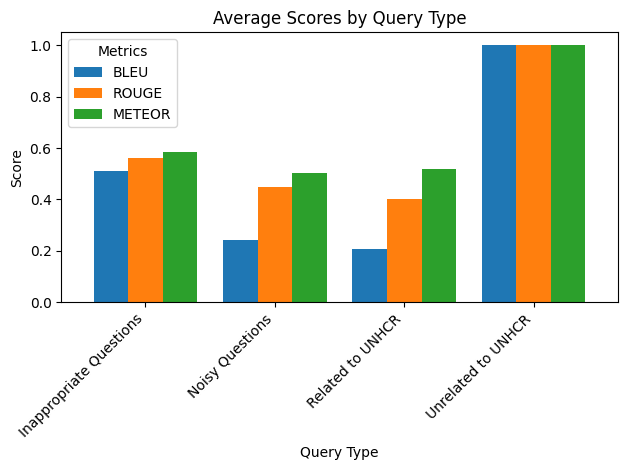

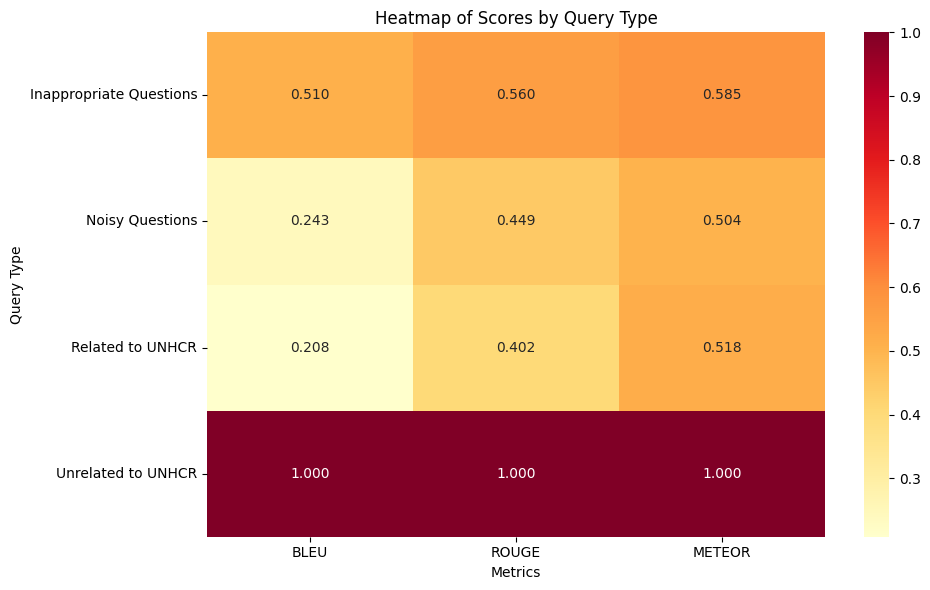


Average Time of Queries:
Query Type
Inappropriate Questions    12.797746
Noisy Questions            12.300041
Related to UNHCR           12.295743
Unrelated to UNHCR          8.484227
Name: Total Time, dtype: float64

Overall Average Time: 11.945 seconds


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

"""
Analyze scores (BLEU, ROUGE, METEOR) grouped by query type.
Visualize average scores and response times using:
- Bar plots
- Heatmaps

This reveals which query categories the chatbot handles well or struggles with. 
This is useful for comparing agains previous versions of the pipeline.
"""

# Read the Excel file
df = pd.read_excel("../Evaluation/Component Evaluation with Scores 02.xlsx")

# Calculate average scores by Query Type
avg_scores = df.groupby('Query Type')[['BLEU', 'ROUGE', 'METEOR']].mean()
print("\nAverage Scores by Query Type:")
print(avg_scores)

# Create a bar plot
plt.figure(figsize=(12, 6))
avg_scores.plot(kind='bar', width=0.8)
plt.title('Average Scores by Query Type')
plt.xlabel('Query Type')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(avg_scores, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Heatmap of Scores by Query Type')
plt.xlabel('Metrics')
plt.ylabel('Query Type')
plt.tight_layout()
plt.show()

# Calculate average time
avg_time = df.groupby('Query Type')['Total Time'].mean()
print("\nAverage Time of Queries:")
print(avg_time)
overall_avg_time = df['Total Time'].mean()
print(f"\nOverall Average Time: {overall_avg_time:.3f} seconds")

#### 7.3 Evaluation of Multilingual Capabilities

This section is dedicated to test the model's multilingual capability using:
- Arabic queries translated by a native speaker
- Ukrainian queries assisted by AI

Purpose: Evaluate chatbot accessibility for refugees from high-volume language groups.

Note: Manual validation was limited due to language constraints, but multilingual embedding models ensure future compatibility.


**Arabic**

In [ ]:
# Query translation in English: "What does UNHCR do in Denmark?"

arabic_query_1 = "ماذا تفعل UNHCR في الدنمارك؟"
generate_answer_without_reformulation(arabic_query_1)	

'UNHCR in Denmark works to protect the rights of temporary protection beneficiaries, asylum-seekers, refugees, and stateless persons, providing support and services free of charge. UNHCR supports national authorities in executing their duties according to international and European standards, but is not involved in the Danish asylum procedure, which is managed by the Danish Immigration Service. For further information, please visit: https://help.unhcr.org/denmark/about-unhcr-in-denmark/'

In [35]:
# Query translation in English: "How can I apply for family reunification?"

arabic_query_2 = "كيف يمكنني ان اقدّم بطلب لم شمل الأسرة؟"
generate_answer_without_reformulation(arabic_query_2)	

"To apply for family reunification in Denmark, you must be a legal resident. Visit the Danish Immigration Service's website (https://nyidanmark.dk) for detailed guidelines and the application form. If your application is rejected, you can appeal on their online portal (English: https://nyidanmark.dk/en-GB/You-have-received-an-answer/Family/Family-reunification/No-to-family-reunification/, Danish: https://nyidanmark.dk/da/ReceivedReply/Family/Family%20reunification/No%20to%20family%20reunification). For additional information, please refer to the provided links."

In [ ]:
# Query translation in English: "How do I apply for asylum in Denmark?"

arabic_query_3 = "كيف يمكنني ان اقدّم بطلب اللجوء؟"
generate_answer_without_reformulation(arabic_query_3)	   

"To apply for asylum in Denmark, you can follow the process outlined on the UNHCR website: https://help.unhcr.org/denmark/uk/how-to-apply-for-asylum-in-denmark/how-to-apply-for-asylum/. Regardless of your current residency status, the application procedure can vary, so it's important to check the specific requirements for your situation. For additional information, please visit: https://help.unhcr.org/denmark/uk/how-to-apply-for-asylum-in-denmark/how-to-apply-for-asylum/"

In [37]:
# Query translation in English: "Can I appeal a negative asylum decision?"

arabic_query_4 = "هل يمكنني الاستئناف على قرار اللجوء؟"
generate_answer_without_reformulation(arabic_query_4)

"If your asylum application is denied, your case is automatically appealed to the Danish Refugee Appeals Board. You don't need to take any action to start the appeal process as it's handled by the board. For more information, please visit: https://help.unhcr.org/denmark/uk/how-to-apply-for-asylum-in-denmark/can-i-appeal-a-negative-decision/."

In [38]:
# Query translation in English: "Where do I go to apply for asylum in Denmark?"

arabic_query_5 ="أين أذهب لتقديم طلب اللجوء؟"
generate_answer_without_reformulation(arabic_query_5)



'To submit a refugee status application in Denmark, you must apply at the Danish Immigration Service (UDI). Visit their official website or contact them directly for detailed instructions on the application process. For additional information, please refer to: https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/what-are-my-rights-and-obligations-as-asylum-seeker/.'

**Ukrainian**

In [ ]:
# Query translation in English: "What does UNHCR do in Denmark?"

ukrainian_query_1 = "Чим займається УВКБ ООН в Данії?"
generate_answer_without_reformulation(ukrainian_query_1)

'UNHCR in Denmark supports the national authorities in executing their duties according to international and European standards, but does not partake in the family reunification process. This process is managed by the Danish Immigration Service under the Danish Ministry of Immigration and Integration. For additional information, please visit: https://help.unhcr.org/denmark/uk/about-unhcr-in-denmark/, https://help.unhcr.org/denmark/uk/applying-for-family-reunification/applying-for-family-reunification/.'

In [40]:
# Query translation in English: "How can I apply for family reunification?"

ukrainian_query_2 = "Як я можу подати заяву на возз'єднання сім'ї?"
generate_answer_without_reformulation(ukrainian_query_2)

'You can apply for family reunification through the online portal of the Danish immigration authorities. Visit https://nyidanmark.dk/en-GB/You-want-to-apply/Family/Family-reunification for English, or https://nyidanmark.dk/da/Applying/Familie/Familiesammenforing for Danish. For additional information, please visit: https://help.unhcr.org/denmark/uk/applying-for-family-reunification/applying-for-family-reunification/, https://help.unhcr.org/denmark/applying-for-family-reunification/.'

In [41]:
# Query translation in English: "How do I apply for asylum in Denmkark?"

ukrainian_query_3 = "Як подати заяву на отримання притулку в Данії??"
generate_answer_without_reformulation(ukrainian_query_3)

'Watch a video guide in Ukrainian to apply online for Temporary Protection by the Danish Immigration Service at https://www.nyidanmark.dk/en-GB/You-want-to-apply/Ukraine/Displaced-from-Ukraine?anchor=howtoapply. Additionally, for more detailed steps, visit https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/.'

In [42]:
# Query translation in English: "Can I appeal a negative asylum decision?"

ukrainian_query_4 = "Чи можу я оскаржити негативне рішення про надання притулку??"
generate_answer_without_reformulation(ukrainian_query_4)

'Если ваше притулкове прийняття буде відмовлено, ви отримаєте рішення в письмовому повідомленні, що включає причини відмови. Процес автоматично перейде на Danish Refugee Appeals Board без необхідності у вас подані подальших кроків. Для детальної інформації про процес оскарження наданого рішення, відвідайте: https://help.unhcr.org/denmark/how-to-apply-for-asylum-in-denmark/can-i-appeal-a-negative-decision/.'

In [43]:
# Query translation in English: "Who won the last Super Bowl?"

ukrainian_query_5 = "Хто виграв останній Суперкубок??"
generate_answer_without_reformulation(ukrainian_query_5)

"I'm sorry, I can only answer questions related to UNHCR and refugee services in Denmark."